In [1]:
#Libraries
import re
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import keras
from keras.models import load_model
from keras.layers import *
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras import backend as K
from keras import layers


import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
def processed_data(data):
    data=data.drop(columns=["Unnamed: 0"])
    data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
    data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    y = pd.get_dummies(data['Basic']).values

    return data,y

In [3]:
def DA_label_count(data):
    label_count=data.groupby('Basic')['Basic'].agg('count')
    label_count.to_numpy(dtype=int)
    label_count = np.expand_dims(label_count, axis=0)
    label_count.shape=(5,1)
    labels=np.array(['B', 'D', 'F', 'Q', 'S'])
    labels.shape=(5,1)
    label_count=np.column_stack((labels,label_count))
    df = pd.DataFrame(label_count, columns=['Label', 'Count'])
    convert_dict = {
                    'Label': str,
                    'Count': int
                   }  
    df = df.astype(convert_dict)
    return df

In [4]:
full_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\full_set.csv')
MAX_PADDING = 100
def x_value(data):
    tokenizer = Tokenizer(num_words = 5000, split=" ")
    tokenizer.fit_on_texts(full_data['Utterances'].values)
    x = tokenizer.texts_to_sequences(data['Utterances'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_PADDING)
    
    return x

In [5]:
train_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\train.csv')
train_data,y_train = processed_data(train_data)
x_train = x_value(train_data)

val_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\val.csv')
val_data,y_val = processed_data(val_data)
x_val = x_value(val_data)

test_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\test.csv')
test_data,y_test = processed_data(test_data)
x_test = x_value(test_data)

In [6]:
inputs1=Input(shape=(100,))

x1=Embedding(input_dim=5000,
             output_dim=300,
             input_length=100,
             embeddings_regularizer=keras.regularizers.l2(.001))(inputs1)

x1=Bidirectional(LSTM(units=20,
                      dropout=0.3,
                      recurrent_dropout=0.2,
                      return_sequences = False))(x1)

output=Dense(5,activation='softmax')(x1) 
model=keras.Model(inputs1,output)

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          1500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                51360     
_________________________________________________________________
dense (Dense)                (None, 5)                 205       
Total params: 1,551,565
Trainable params: 1,551,565
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=1, 
                                               verbose=1)

hist = model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32, 
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val))

Epoch 1/100
2346/2346 [==============================] - 317s 134ms/step - loss: 0.7418 - accuracy: 0.7515 - val_loss: 0.7313 - val_accuracy: 0.7527
Epoch 2/100
2346/2346 [==============================] - 346s 147ms/step - loss: 0.6617 - accuracy: 0.7780 - val_loss: 0.7164 - val_accuracy: 0.7584
Epoch 3/100
2346/2346 [==============================] - 349s 149ms/step - loss: 0.6494 - accuracy: 0.7830 - val_loss: 0.7058 - val_accuracy: 0.7637
Epoch 4/100
2346/2346 [==============================] - 333s 142ms/step - loss: 0.6421 - accuracy: 0.7865 - val_loss: 0.7076 - val_accuracy: 0.7652
Epoch 5/100
2346/2346 [==============================] - 336s 143ms/step - loss: 0.6377 - accuracy: 0.7892 - val_loss: 0.7147 - val_accuracy: 0.7658
Epoch 6/100
2346/2346 [==============================] - 334s 142ms/step - loss: 0.6369 - accuracy: 0.7883 - val_loss: 0.7008 - val_accuracy: 0.7712
Epoch 00006: early stopping


In [9]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 100


def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

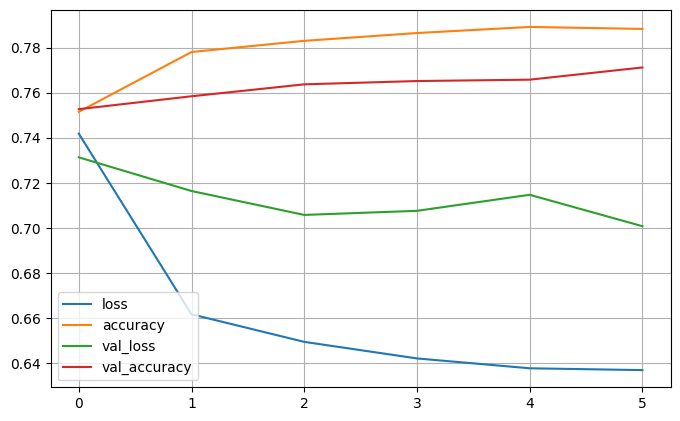

In [10]:
plot(hist)

In [11]:
model.evaluate(x_test, y_test)

522/522 [==============================] - 9s 18ms/step - loss: 0.6628 - accuracy: 0.7756


[0.6627858281135559, 0.7755823135375977]

In [12]:
y_pred = model.predict(x_test)

In [13]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)


from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1873    1   22    3  253]
 [  71 1219  111   67  871]
 [ 170  138 1019    8   73]
 [ 258   81    0  406  486]
 [ 776  260   27   72 8436]]


In [14]:
from sklearn.metrics import f1_score
print("F1 score(macro)",f1_score(y_test, y_pred, average='macro'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))

F1 score(macro) 0.6819232549545299
F1 score(micro) 0.7755823004610503


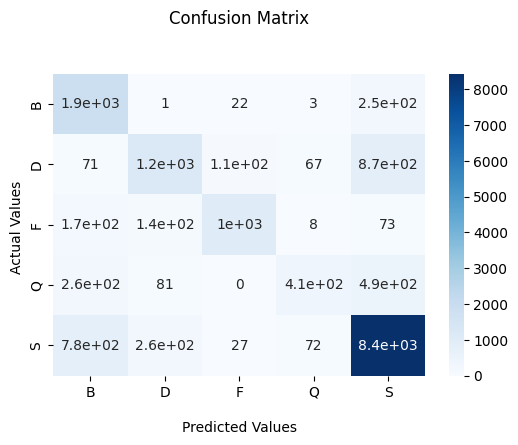

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(confusion, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['B','D','F','Q','S'])
ax.yaxis.set_ticklabels(['B','D','F','Q','S'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
DA = np.array(['B','D','F','Q','S'])
a = ["will you go",
     "Not at all",
     "uh um"]
tokenizer = Tokenizer(num_words = 5000, split=" ")
full_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\full_set.csv')
tokenizer.fit_on_texts(full_data['Utterances'].values)
a = tokenizer.texts_to_sequences(a)
a = np.array(a)
a = pad_sequences(a, padding='post', maxlen=100)
prediction = model.predict(np.array(a))
print(DA[prediction.argmax(1)])

['Q' 'S' 'F']


C:\Users\user1\AppData\Local\Temp/ipykernel_6732/907893161.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(a)


In [17]:
model.save('SAVED_MODEL.h5')